In [ ]:
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as kutils
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from numpy.random import seed
import pandas as pd

from typing import List, Optional, Iterable, Any, Tuple, Dict
import functools
import itertools
import re
import subprocess
from io import StringIO

# A special keras layer I was experimenting with
# from nalu import NALU

In [ ]:
from IPython.display import display,Image
import ipywidgets as widgets

In [ ]:
import Parse_SOM

In [ ]:
# def properties_dataframe_from_file(path: str):
#     property_lists = TEM_SOM.parsing_refined_data(path)
#     frame = pd.DataFrame(index=property_lists[0], data={'Toughness': property_lists[1], 'Ductility index': property_lists[2], 
#                                                         'Fracture toughness': property_lists[3], 'Melting point': property_lists[4], 
#                                                         'Thermal conductivity': property_lists[5], 'Specific heat capacity': property_lists[6], 
#                                                         'Thermal distortion resistance': property_lists[7], 
#                                                         'Thermal expansion coefficient': property_lists[8], 
#                                                         #'Thermal shock resistance': property_lists[9], # Disabling this property since it's computed
#                                                         'Latent heat of fusion': property_lists[10], 'Electrical conductivity': property_lists[11], 
#                                                         'Mechanical loss coefficient': property_lists[12]})
        
#     frame.replace("Null", np.nan, inplace=True)
    
#     display(frame.count())
#     for entry in frame.count():
#         display(entry)
#     frame.dropna(inplace=True)
#     print(f"After dropping nulls: {len(frame.index)}")
#     return frame

In [ ]:
def model(input_dim: int, hidden_layers: List[Any], optimizer: Any=None, **kwargs):
    """
    Creates a Keras model when given a few parameters describing the desired structure
    
    :param input_dim: The dimension of the input tensor
    :param hidden_layers: The layout for output tensors.
        This is a mixed list containing integers and Keras layers. Integers are turned into dense layers, 
        Keras layers are inserted verbatim.
    :param optimizer: The optimizer that the model should use. 
        Should be any object that keras will accept as a model "optimizer".
        Examples include 'adam', 'rmsprop', or keras.optimizers.RMSprop(0.001)
    
    :returns model: An empty Keras model
    """
    learn_rate = kwargs.get("learn_rate", 0.001)
    model = models.Sequential()
    model.add(layers.Dense(input_dim, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    for layer_descriptor in hidden_layers:
        if type(layer_descriptor) is int:
            # Ints turn into a simple dense layer
            model.add(layers.Dense(layer_descriptor, kernel_initializer='normal', activation='relu'))
        else:
            model.add(layer_descriptor)
    optimizer = optimizer or keras.optimizers.RMSprop(learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse','mae'])
    return model

# All Legit Properties:
 * 'Youngs_modulus',
 * 'Yield_strength',
 * 'Tensile_strength',
 * 'Compressive_strength',
 * 'Flexural_modulus',
 * 'Flexural_strength',
 * 'Shear_modulus',
 * 'Bulk_modulus',
 * 'Poisson_ratio',
 * 'Shape_Factor',
 * 'Fatigue_strength',
 * 'Fracture_toughness',
 * 'Melting_point',
 * 'Max_service_temp',
 * 'Min_service_temp',
 * 'Thermal_conductivity',
 * 'Specific_heat_capacity',
 * 'Thermal_expansion_coefficient',
 * 'Latent_heat_of_fusion',
 * 'Electrical_resistivity',
 * 'Electrical_conductiviy',
 * 'Galvanic_potential',
 * 'Mechanical_loss_coefficient'

# Representative Properties:
    - Youngs_modulus
    - Yield_strength
    - Poisson_ratio
    - Shape_factor
    - Thermal_conductivity
    - Electrical_conductivity
    - Latent_heat_of_fusion
    - Thermal_expansion_coefficient
    - Specific_heat_capacity
    - Material_family (via one-hot) (Possibly?)
    - Melting_point

In [ ]:
DATA_PATH = 'data/Updated_PCM.csv'
DATA_PATH_2 = 'data/pythoncleanedgranta.csv'
ALL_PROPERTIES = ['Youngs_modulus', 
                  'Yield_strength', 
                  'Poisson_ratio', 
                  'Shape_factor', 
                  'Thermal_conductivity', 
                  'Electrical_conductivity', 
                  'Latent_heat_of_fusion', 
                  'Thermal_expansion_coefficient', 
                  'Melting_point',
                  'Specific_heat_capacity']

In [ ]:
properties_df = Parse_SOM.properties_dataframe_from_file(DATA_PATH)

som_columns = [*map(lambda a: a.replace(' ', '_'), (x for x in Parse_SOM.COLUMN_NAMES if x != "Material family"
                     and x not in Parse_SOM.BAD_PROPERTIES))]

properties_df.columns = map(lambda x: x.replace(' ', '_'), properties_df.columns)

# Only drop NaN entries for the columns we're training on
#properties_df.dropna(inplace=True)
#properties_df = pd.read_csv(DATA_PATH_2, index_col=0)

In [ ]:
len(properties_df.index)

In [ ]:
# properties_df.dropna(subset=ALL_PROPERTIES, inplace=True)

In [ ]:
# # This line drops entries for all 22 properties
# # This is going to hurt our volume quite a bit

# # NOTE: This SUBSTANTIALLY changes the character of the dataset
print(len(properties_df.index))
properties_df.dropna(subset=som_columns, inplace=True)
print(len(properties_df.index))

In [ ]:
def standardize_dataframe(frame_to_norm: pd.DataFrame, means: pd.Series, std_devs: pd.Series):
    """
    frame_to_norm:
        the dataframe to normalize
    means:
        Pandas series of means of each property
    std_devs:
        Pandas series of std deviations of each property
    """
    return (frame_to_norm - means) / std_devs

In [ ]:
def data_preprocess_standardize(host_dataset: pd.DataFrame, train_data: pd.DataFrame, test_data: pd.DataFrame):
    frame_stats = host_dataset.describe().transpose()
    train_stdized = (train_data - frame_stats['mean']) / frame_stats['std']
    test_stdized = (test_data - frame_stats['mean']) / frame_stats['std']
    return (train_stdized, test_stdized)

In [ ]:
def data_preprocess_normalize(host_dataset: pd.DataFrame, train_data: pd.DataFrame, test_data: pd.DataFrame):
    frame_stats = host_dataset.describe().transpose()
    # 0: minimum
    # 1: maximum
    train_normalized = (train_data - frame_stats['min']) / (frame_stats['max'] - frame_stats['min'])
    test_normalized = (test_data - frame_stats['min']) / (frame_stats['max'] - frame_stats['min'])
    for c in train_normalized.columns:
        if not (train_normalized[c] <= 1).all() and (train_normalized[c] >= 0).all():
            display(train_normalized)
            assert False
        if train_normalized.isnull().sum().any():
            display(train_normalized.isnull().sum())
            assert False
    return (train_normalized, test_normalized)

In [ ]:
import io
import csv
from typing import Iterable, IO
import pandas as pd
import itertools

def norm_dataframe(frame_to_norm: pd.DataFrame, host_dataset: pd.DataFrame):
    """
    frame_to_norm:
        the dataframe to normalize
    host_dataset:
        the larger dataframe that the first dataframe is contained in
    """
    frame_stats = host_dataset.describe().transpose()
    return (frame_to_norm - frame_stats['mean']) / frame_stats['std']

def create_neopulse_dataframe(my_df: pd.DataFrame, input_properties: Iterable[str], output_properties: Iterable[str], output_file: IO):
    """
    Given a pandas dataframe, columns, and an IO object to write to, creates a csv file compatible with neopulse
    """
    normed_dataframe = norm_dataframe(my_df[list(itertools.chain(input_properties, output_properties))], my_df)
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(['input', 'output', 'name'])
    for (name, row), (_, norm_row) in zip(my_df.iterrows(), normed_dataframe.iterrows()):
        csv_writer.writerow(['|'.join(map(str, row[output_properties])), '|'.join(map(str, norm_row[input_properties])), name])

In [ ]:
with io.StringIO() as buffer:
    create_neopulse_dataframe(properties_df, [x for x in som_columns if x not in ["Youngs_modulus"]], ["Youngs_modulus"], buffer)
    print(buffer.getvalue())

In [ ]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

In [ ]:
def prepare_data(base_dataset: pd.DataFrame, input_props: List[str], output_prop: str, random_seed: int=0, data_preprocessor=None, train_frac=None):
    # Aped from https://www.tensorflow.org/tutorials/keras/basic_regression
    # this smells like it could be replaced by skl's `train_test_split` or something
    cloned_dataset = base_dataset.filter(items=itertools.chain(input_props, [output_prop])).copy()
    clone2 = cloned_dataset.copy()
    # This is where 20% of the data is set aside for testing
    # 80% is dedicated to either validation or training
    if train_frac is None:
        train_frac = 0.8
    train_dataset = cloned_dataset.sample(frac=train_frac, random_state=random_seed)
    test_dataset = cloned_dataset.drop(train_dataset.index)
    
    train_labels = train_dataset.pop(output_prop)
    test_labels = test_dataset.pop(output_prop)
    
    train_stats = train_dataset.describe()
    # Deleted a line here which was a bogus double pop
    train_stats = train_stats.transpose()
    
    if data_preprocessor is None:
        data_preprocessor = data_preprocess_standardize
    # This normalization needs to be applied to all input information
    
    normed_train_data, normed_test_data = data_preprocessor(clone2[input_props], train_dataset, test_dataset)
    del cloned_dataset
    del clone2
    return normed_train_data, train_labels, normed_test_data, test_labels

In [ ]:
def train_nn(my_model: models.Model, base_dataset: pd.DataFrame, input_props: List[str], output_prop: str, 
          es_monitor: str='val_loss', es_patience: int=20, data_split_seed: int=0, data_preprocessor: Any=None, **kwargs):
    """
    Trains a model and returns various important parameters regarding it.
    
    :param my_model: A Keras model to train.
    :param base_dataset: The complete dataset to learn and predict on.
    :param input_props: The properties to use for predicting.
    :param output_prop: The property to predict.
    :param es_monitor: The metric to monitor for the EarlyStopping system.
    :param es_patience: How many training epochs without improvement that the EarlyStopping callback should wait for.
    
    :returns training_history, (testing_labels, testing_results), normed_test_data
        training_history is a History object containing information about how the model improved over training epochs
        testing_labels is a numpy array of the correct values for the output_prop
        testing_results is a numpy array of the predicted values for the output_prop
        normed_test_data is a pandas dataframe containing the normed dataset used for training
    """
    EPOCHS = kwargs.get("epochs", 250)
    TRAIN_FRAC = kwargs.get('train_frac', 0.8)
    normed_train_data, train_labels, normed_test_data, test_labels = \
        prepare_data(base_dataset, input_props, output_prop, random_seed=data_split_seed, data_preprocessor=data_preprocessor, train_frac=TRAIN_FRAC)
   
    VAL_SPLIT = kwargs.get('val_frac', 0.2)
    if data_split_seed:
        seed(data_split_seed)
    # Here's where the model actually trains
    history = my_model.fit( \
        normed_train_data.values, train_labels.values, \
        epochs = EPOCHS, validation_split = VAL_SPLIT, verbose = 0, 
                           callbacks = [PrintDot(),
                                        keras.callbacks.TerminateOnNaN(), 
                                        keras.callbacks.EarlyStopping(monitor=es_monitor, patience=es_patience),
                                       ])
    # Return arguments:
    # training_history, (testing_labels, testing_results), normed_test_data
    return history, (test_labels.values, my_model.predict(normed_test_data.values).flatten()), normed_test_data

In [ ]:
def train_rf(forest: RandomForestRegressor, base_dataset: pd.DataFrame, input_props: List[str], output_prop: str, **kwargs):
    """
    Trains a model and returns various important parameters regarding it.

    :param forest: The random forest regressor to use.
    :param base_dataset: The complete dataset to learn and predict on.
    :param input_props: The properties to use for predicting.
    :param output_prop: The property to predict.
    
    :returns (testing_labels, testing_results), normed_test_data
        testing_labels is a numpy array of the correct values for the output_prop
        testing_results is a numpy array of the predicted values for the output_prop
        normed_test_data is a pandas dataframe containing the normed dataset used for training
    """
    
    prep_data_args = { k: kwargs[k] for k in ['random_seed', 'data_preprocessor', 'train_frac'] if k in kwargs }
    normed_train_data, train_labels, normed_test_data, test_labels = \
        prepare_data(base_dataset, input_props, output_prop, **prep_data_args)
    
    fit_args = { k: kwargs[k] for k in ['sample_weight'] if k in kwargs }
    
    if 'random_seed' in kwargs:
        seed(kwargs['random_seed'])
    # Here's where the model actually trains
    forest.fit(normed_train_data, train_labels, **fit_args)
    # Return arguments:
    # (testing_labels, testing_results), normed_test_data, (train_labels, train_results)
    return (test_labels.values, forest.predict(normed_test_data).flatten()), normed_test_data, (train_labels.values, forest.predict(normed_train_data).flatten())

def plot_history_direct(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(f'Mean Abs Error [{OUTPUT_DIM}]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    plt.ylim(bottom = 0)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(f'Mean Square Error [${OUTPUT_DIM}^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    plt.ylim(bottom = 0)

my_history = train(my_model, properties_df, INPUT_DIMS, OUTPUT_DIM)

plot_history_direct(my_history)

This is the correlation matrix for Jimin/Nam's dataset.

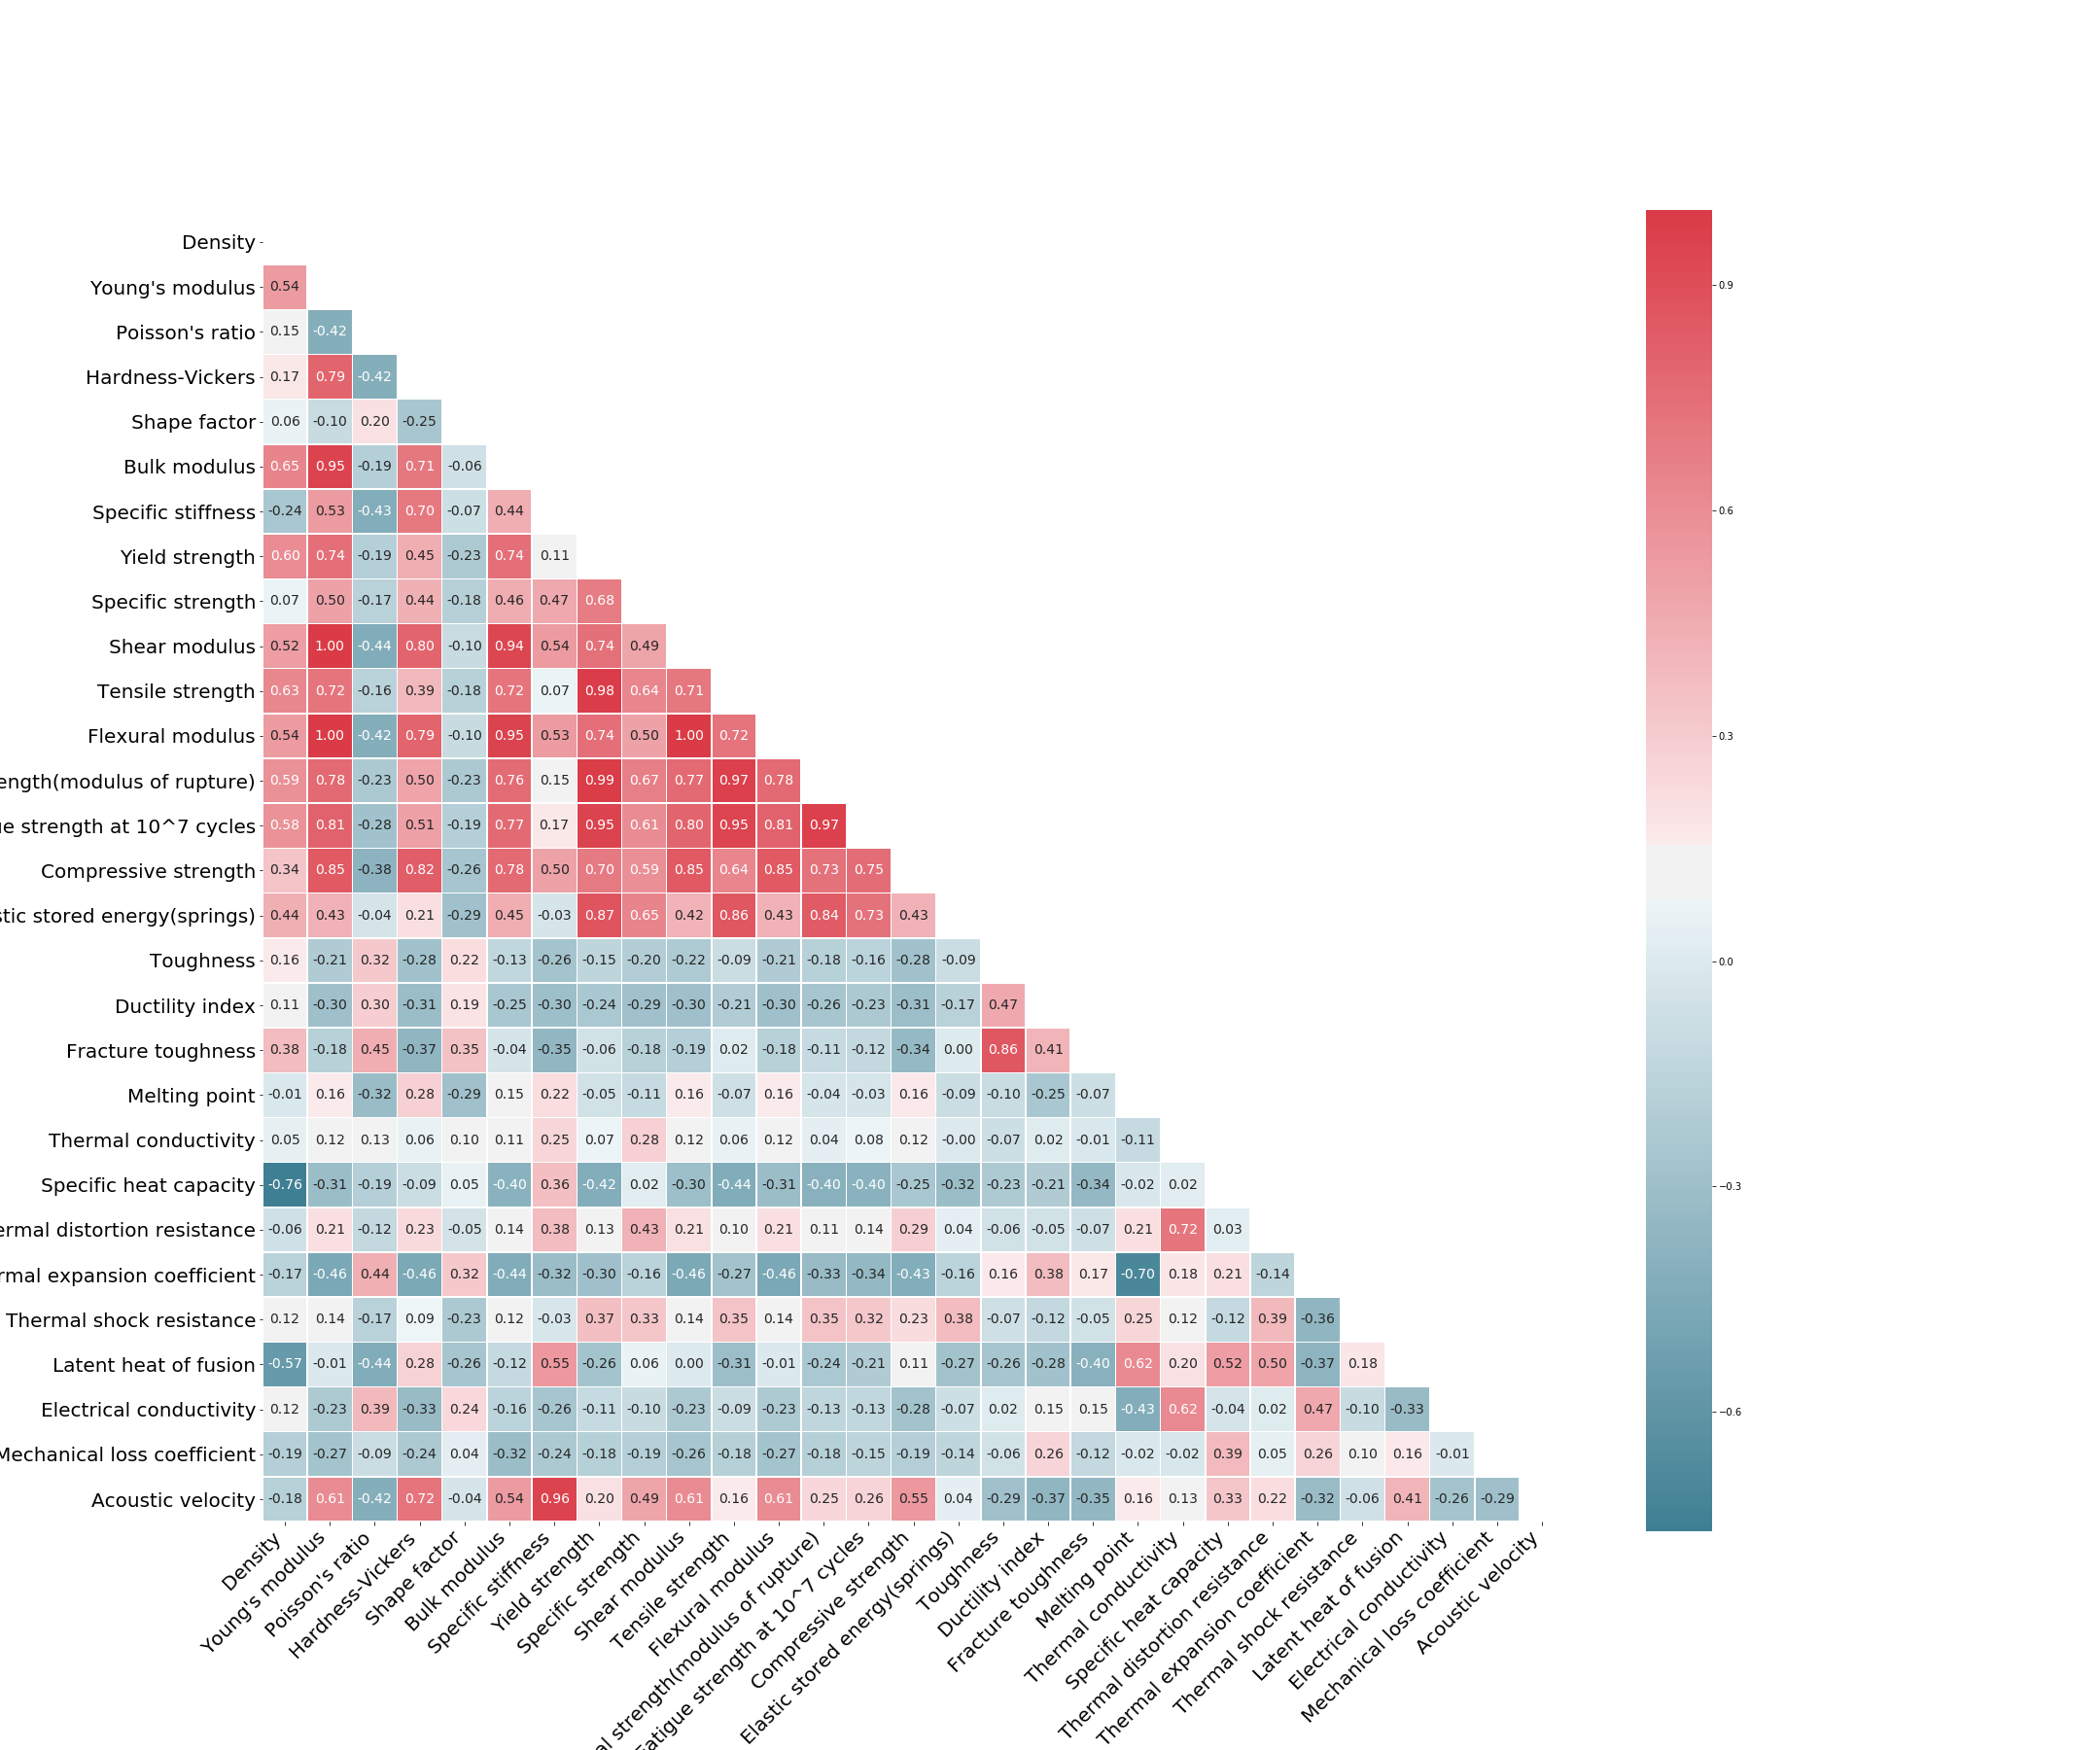

In [ ]:
def corr_matrix(prop_df:pd.DataFrame, usecols:List[str]=None, cmap=None, figsize=(12, 9)):
    """
    Creates a correlation matrix from a dataframe. Directly renders the figure.
    FIXME: Return a figure instead, and call show on that later
    
    :param prop_df: The dataframe of properties to correlate.
    :param usecols: A list of property names to use in the plot
    """
    # This filters out all string and object columns, which cannot be correlated
    numeric_columns = [col for col in prop_df.columns if prop_df[col].dtype.char not in "OSU"]

    # Default to all numeric columns of the dataframe
    usecols = usecols or numeric_columns
    # calculate correlation matrix from pandas DaraFrame
    corr_mat = np.corrcoef(prop_df[usecols].values.T)
    # The following one also works well and return DataFrame (might be slower)
    # corr_mat = prop_df[usecols].corr()
    display(prop_df[usecols].corr())

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # create figure instance
    sns.set_style('white')
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Generate a Seaborn colormap
    cmap = cmap or sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    cax = fig.add_axes([0.75, 0.2, 0.02, 0.5])  # shift color bar
    sns.heatmap(corr_mat, mask=mask, cmap=cmap,
                vmax=1., vmin=-1.,
                center=0,
                square=True, linewidths=.5,
                cbar_ax=cax,
                # cbar_kws={'shrink': .6},
                xticklabels=usecols[:-1] + [''], yticklabels=[''] + usecols[1:],
                annot=True, annot_kws={'fontsize': 14}, fmt='.2f', ax=ax)
    # This was labeling the objects incorrectly.
    # This does not seem to be the labeling scheme used by Jimin's correlation
    # matrix
#     # Are we sure this is labeling the objects correctly?
#     # compared to the pandas dataframe, this does not look correct
#     # empty string to last element of usecols
#     xlabels = np.append(usecols[:-1], '')
#     # empty string to first element of usecols and inverse order of list
#     ylabels = np.append(usecols[:-1], '')
#     ax.set_yticklabels(ylabels, rotation=0)

    plt.show()

In [ ]:
corr_matrix(properties_df, usecols=ALL_PROPERTIES)

In [ ]:
corr_matrix(properties_df, usecols=som_columns, figsize=(24,20))

In [ ]:
# Danger: Big
# Also need to drop NaN entries here
# corr_matrix(properties_df)

In [ ]:
properties_df.describe()

In [ ]:
def plot_history(history, output_prop):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
#     fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 7))
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(f'Mean Abs Error [{output_prop}]')
    ax1.plot(hist['epoch'], hist['mae'],
           label='Train Error', linewidth=3)
    ax1.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error', linewidth=3)
    ax1.legend()
    ax1.set_ylim(bottom = 0)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(f'Root Mean Square Error [$sqrt({output_prop}^2)$]')
    ax2.plot(hist['epoch'], np.sqrt(hist['mse']),
           label='Train Error')
    ax2.plot(hist['epoch'], np.sqrt(hist['val_mse']),
           label = 'Val Error', linewidth=3)
    ax2.legend()
    ax2.set_ylim(bottom = 0)
    return fig, (ax1,)

In [ ]:
def plot_test_results_to_axes(ax: mpl.axes.Axes, propname: str, labels: np.ndarray, predictions: np.ndarray, error_ratio=0.2, use_logscale=False):
    """
    Plots test results onto a given matplotlib axes
    """
    ax.scatter(labels, predictions)
    ax.set_aspect('equal')
    ax.set_xlabel(f"True Value [{propname}]")
    ax.set_ylabel(f"Predicted Value [{propname}]")
    
    
        
    
    far_bounds = np.concatenate([labels, predictions, [0]])
        
    far_bound_upper = far_bounds.min()
    far_bound_lower = far_bounds.max()
    
#     smallest_positive_element = np.fmax(far_bounds)
    
    if use_logscale:
        pass
#         ax.set_xscale('symlog', linthreshx=)
#         ax.set_yscale('symlog')
    line1, = ax.plot([far_bound_lower, 0, far_bound_upper], [far_bound_lower, 0, far_bound_upper]) # (far_bound_lower, far_bound_lower) (0, 0) (far_bound_upper, far_bound_upper)
    
    error_line_upper_magnitude = far_bound_upper*(1-error_ratio)
    error_line_lower_magnitude = far_bound_lower*(1-error_ratio)
    ax.plot([far_bound_lower, 0, far_bound_upper], [error_line_lower_magnitude, 0, error_line_upper_magnitude], color=line1.get_color(), linestyle="--") # (0, 0) (far_bound, far_bound/2)
    ax.plot([error_line_lower_magnitude, 0, error_line_upper_magnitude], [far_bound_lower, 0, far_bound_upper], color=line1.get_color(), linestyle="--") # (0, 0) (far_bound/2, far_bound)

In [ ]:
# The unique categories for material family
# We can use this to create several one-hot fields that describe what category of material this is
# This may be useful in dividing regression into various regimes
set(properties_df.Material_family.values)

In [ ]:
# This creates "one-hot" columns in the dataframe, that allow incorporating categorical information into decision making
properties_df = properties_df.assign(
    is_metal=lambda x: x.Material_family.map(lambda s: int(s.startswith("Metal"))),
    is_precious_metal=lambda x: x.Material_family.map(lambda s: int(s == "Metal (precious)")),
    is_ferrous_metal=lambda x: x.Material_family.map(lambda s: int(s == "Metal (ferrous)")),
    is_nonferrous_metal=lambda x: x.Material_family.map(lambda s: int(s == "Metal (non-ferrous)")),
    is_other_metal=lambda x: x.Material_family.map(lambda s: int(s == "Metal (other)")),
    is_ceramic=lambda x: x.Material_family.map(lambda s: int(s.startswith("Ceramic")))
)

In [ ]:
NN_properties = [x for x in som_columns if x != "Electrical_resistivity"] + [
    "is_metal",
    "is_precious_metal",
    "is_ferrous_metal",
    "is_nonferrous_metal",
    "is_other_metal",
    "is_ceramic"
]

In [ ]:
# will want to rework this to be able to predict more than 1 property
# We need: 
#     generated model
#     training history
#     test set labels
#     test set predictions
#     normed test data
def run_neural_net(input_dataframe: pd.DataFrame, input_props: List[str], output_prop: List[str], 
                   hidden_layers: Optional[List[Any]]=None, es_monitor: str='val_loss', es_patience: int=20, 
                    optimizer: Any=None, data_split_seed: Optional[int]=None, data_preprocessor: Any=None,
                  train_frac: Optional[float]=None) \
        -> Tuple[models.Model, keras.callbacks.History, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    This actually runs the neural net.
    """
    hidden_layers = hidden_layers or [12, 1]
    my_model = model(len(input_props), hidden_layers, optimizer=optimizer)
    hist = None
    test_results = None
    normed_test_data = None
    # This is where all the magic happens
    hist, (testdata_labels, testdata_predictions), normed_test_data = \
        train_nn(my_model, input_dataframe, input_props, output_prop,
              es_monitor=es_monitor, es_patience=es_patience,
              data_split_seed=data_split_seed, data_preprocessor=data_preprocessor, train_frac=train_frac)
    return my_model, hist, testdata_labels, testdata_predictions, normed_test_data

In [ ]:
# will want to rework this to be able to predict more than 1 property
# We need: 
#     generated model
#     training history
#     test set labels
#     test set predictions
#     normed test data
def run_random_forest(input_dataframe: pd.DataFrame, input_props: List[str], output_prop: List[str], 
                   hidden_layers: Optional[List[Any]]=None, es_monitor: str='val_loss', es_patience: int=20, 
                    optimizer: Any=None, data_split_seed: Optional[int]=None, data_preprocessor: Any=None,
                     train_frac: Optional[float]=None, num_trees: int=20) \
        -> Tuple[RandomForestRegressor, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    This actually runs the random forest.
    """
    my_forest = RandomForestRegressor(n_estimators=num_trees)
    # This is where all the magic happens
    (testdata_labels, testdata_predictions), normed_test_data, (traindata_labels, traindata_predictions) = \
        train_rf(my_forest, input_dataframe, input_props, output_prop,
              random_seed=data_split_seed, data_preprocessor=data_preprocessor, train_frac=train_frac)
    return my_forest, testdata_labels, testdata_predictions, normed_test_data, traindata_labels, traindata_predictions

In [ ]:
def _make_error_dict(mean: float, mean_abs_error: float, mean_sq_error: float):
    # Creates a dictionary containing mean absolute error,
    # root mean square error, and their ratios to the mean
    # Used in functions that create error dataframes
    return {
        'mae': mean_abs_error,
        'mae_over_mean': mean_abs_error/np.abs(mean),
        'rmse': np.sqrt(mean_sq_error),
        'rmse_over_mean': np.sqrt(mean_sq_error)/np.abs(mean),
    }

In [ ]:
def make_error_dataframe(mean: float, history: pd.DataFrame, testdata_labels: np.ndarray, testdata_predictions: np.ndarray) -> pd.DataFrame:
    starter_index = ["Training"]
    starter_data = [
        _make_error_dict(mean, 
                         history['mae'].iloc[-1],
                         history['mse'].iloc[-1])
    ]
    
    # Special handling for the neural network
    if "val_mae" in history.columns:
        starter_index.append("Validation")
        starter_data.append(
            _make_error_dict(mean,
                            history['val_mae'].iloc[-1],
                            history['val_mse'].iloc[-1]))

    errors_dataframe = pd.DataFrame(
        starter_data,
        index=starter_index,
        columns=[
        'mae',
        'mae_over_mean',
        'rmse',
        'rmse_over_mean',
        ])
    
    test_mae = mean_absolute_error(testdata_labels, testdata_predictions)
    test_mse = mean_squared_error(testdata_labels, testdata_predictions)
    
    errors_dataframe.loc["Testing"] = _make_error_dict(
        mean,
        test_mae,
        test_mse)
    return errors_dataframe

In [ ]:
# Given the corresponding dataframe and its set of predictions
# return a labeled list of the outliers?

In [ ]:
def demo_neural_net(w_out: widgets.Output, input_dataframe: pd.DataFrame, input_props: List[str], output_prop: str, 
                    hidden_layers: Optional[List[Any]]=None, 
                    es_monitor: str='val_loss', es_patience: int=20, 
                    optimizer: Any=None, data_split_seed: int=None, data_preprocessor: Any=None):
    """
    demo_neural_net: Given arguments specifying what parameters to regress, and how to do so,
    trains a neural network and displays useful information regarding it into a provided output widget
    
    :param w_out: The Jupyter output widget to put all the desired plots and other figures into.
    :param input_props: The properties to use to make predictions.
    :param output_prop: The property to predict, and use as labels.
    :param hidden_layers: A mixed list of integers and keras layers.
        Integers get transformed into Dense keras layers, while Keras layers get inserted directly into the model.
    :param es_monitor: The parameter that the EarlyStopping system uses to measure meaningful improvement.
    :param es_patience: The number of "training epochs" that the EarlyStopping system will allow for minimal progress.
    """
    with w_out:
        my_model, hist, testdata_labels, testdata_predictions, normed_test_data = \
            run_neural_net(input_dataframe, input_props, output_prop, hidden_layers, es_monitor, es_patience, optimizer, data_split_seed=data_split_seed, data_preprocessor=data_preprocessor)
    hist_fig, hist_axes = plot_history(hist, output_prop)
    res_fig, res_axes = plt.subplots()
    plot_test_results_to_axes(res_axes, output_prop, testdata_labels, testdata_predictions, error_ratio=.15, use_logscale=True)
    properties_stats = properties_df.describe()
    hist2 = pd.DataFrame(hist.history)
    
    errors_dataframe = make_error_dataframe(properties_stats[output_prop]['mean'], hist2, testdata_labels, testdata_predictions)
    
    # This is where "Property masking" occurs
    for prop in input_props:
        masked_test_data = normed_test_data.copy()
        # Replace the column with just the mean (nil out the per-element variance)
        # to make evident what mechanisms the model uses to make estimates
        masked_test_data[prop] = 0
        # This is where the model produced from `train` above is tested again
        masked_predictions = my_model.predict(masked_test_data.values).flatten()
        
        # Use some numpy and scipy routines to calculate the errors
        mae = mean_absolute_error(testdata_labels, masked_predictions)
        mse = mean_squared_error(testdata_labels, masked_predictions)
        errors_dataframe.loc[f"Testing (Masked {prop})"] = _make_error_dict(
            properties_stats[output_prop]['mean'],
            mae,
            mse
        )
    
    with w_out:
        plt.show(hist_fig)
        print(f"Train MAE/mean: {100*errors_dataframe.loc[('Training', 'mae_over_mean')]:.2f}%")
        print(f"Train RMSE/mean: {100*errors_dataframe.loc[('Training', 'rmse_over_mean')]:.2f}%")
        print(f"Val MAE/mean: {100*errors_dataframe.loc[('Validation', 'mae_over_mean')]:.2f}%")
        print(f"Val RMSE/mean: {100*errors_dataframe.loc[('Validation', 'rmse_over_mean')]:.2f}%")
        plt.show(res_fig)
        percent_formatter = lambda x: f"{100*x:2.1f}%"
        # "Right hand side" limit for the dataframe
        max_value = max(1., errors_dataframe['mae_over_mean'].max(), errors_dataframe['rmse_over_mean'].max())
        display(errors_dataframe.style.bar(subset=['mae_over_mean', 'rmse_over_mean'], vmin=0, vmax=max_value)
                .set_caption(f"Model training statistics for {output_prop}").format({
                    'mae_over_mean': percent_formatter,
                    'rmse_over_mean': percent_formatter,
                }))
        
        
    del my_model
    del hist
    del hist2

In [ ]:
def demo_random_forest(w_out: widgets.Output, input_dataframe: pd.DataFrame, input_props: List[str], output_prop: str,
                    data_split_seed: int=None, data_preprocessor: Any=None):
    """
    demo_random_forest: Given arguments specifying what parameters to regress, and how to do so,
    trains a random forest and displays useful information regarding it into a provided output widget
    
    :param w_out: The Jupyter output widget to put all the desired plots and other figures into.
    :param input_props: The properties to use to make predictions.
    :param output_prop: The property to predict, and use as labels.
    """
    with w_out:
        my_forest, testdata_labels, testdata_predictions, normed_test_data, traindata_labels, traindata_predictions = \
            run_random_forest(input_dataframe, input_props, output_prop, data_split_seed=data_split_seed, data_preprocessor=data_preprocessor)
    res_fig, res_axes = plt.subplots()
    plot_test_results_to_axes(res_axes, output_prop, testdata_labels, testdata_predictions, error_ratio=.15, use_logscale=True)
    properties_stats = properties_df.describe()

    mae = mean_absolute_error(traindata_labels, traindata_predictions)
    mse = mean_squared_error(traindata_labels, traindata_predictions)
    
    train_stats = pd.DataFrame(
        [
            {
                "mae": mae,
                "mse": mse,
            }
        ],
        index=["Training"],
        columns=["mae", "mse"]
    )
    
    errors_dataframe = make_error_dataframe(properties_stats[output_prop]['mean'], train_stats, testdata_labels, testdata_predictions)
    
    # This is where "Property masking" occurs
    for prop in input_props:
        masked_test_data = normed_test_data.copy()
        # Replace the column with just the mean (nil out the per-element variance)
        # to make evident what mechanisms the model uses to make estimates
        masked_test_data[prop] = 0
        # This is where the model produced from `train` above is tested again
        masked_predictions = my_forest.predict(masked_test_data).flatten()
        
        # Use some numpy and scipy routines to calculate the errors
        mae = mean_absolute_error(testdata_labels, masked_predictions)
        mse = mean_squared_error(testdata_labels, masked_predictions)
        errors_dataframe.loc[f"Testing (Masked {prop})"] = _make_error_dict(
            properties_stats[output_prop]['mean'],
            mae,
            mse
        )
    
    with w_out:
        print(f"Train MAE/mean: {100*errors_dataframe.loc[('Training', 'mae_over_mean')]:.2f}%")
        print(f"Train RMSE/mean: {100*errors_dataframe.loc[('Training', 'rmse_over_mean')]:.2f}%")
        plt.show(res_fig)
        percent_formatter = lambda x: f"{100*x:2.1f}%"
        # "Right hand side" limit for the dataframe
        max_value = max(1., errors_dataframe['mae_over_mean'].max(), errors_dataframe['rmse_over_mean'].max())
        display(errors_dataframe.style.bar(subset=['mae_over_mean', 'rmse_over_mean'], vmin=0, vmax=max_value)
                .set_caption(f"Model training statistics for {output_prop}").format({
                    'mae_over_mean': percent_formatter,
                    'rmse_over_mean': percent_formatter,
                }))
        
    return my_forest

In [ ]:
def manytrials_neuralnet(w_out: widgets.Output, input_dataframe: pd.DataFrame, input_props: List[str], output_prop: str, 
                    hidden_layers: Optional[List[Any]]=None, 
                    es_monitor: str='val_loss', es_patience: int=20, 
                    optimizer: Any=None, data_split_seed: int=None, data_preprocessor: Any=None, num_trials=20, train_frac=0.8):
    mae_list = []
    rmse_list = []
    properties_stats = input_dataframe.describe()
    prop_mean = properties_stats[output_prop]['mean']
    for i in range(num_trials):
        my_model, hist, testdata_labels, testdata_predictions, normed_test_data = \
            run_neural_net(input_dataframe, input_props, output_prop, hidden_layers, es_monitor, es_patience, optimizer, data_split_seed=data_split_seed, data_preprocessor=data_preprocessor, train_frac=train_frac)
        
        mae = mean_absolute_error(testdata_labels, testdata_predictions)
        mse = mean_squared_error(testdata_labels, testdata_predictions)
        
        mae_list.append(mae)
        rmse_list.append(np.sqrt(mse))
    
    # yes this is a little silly
    avg_mae = sum(mae_list)/num_trials
    avg_rmse = sum(rmse_list)/num_trials
    
    avg_mae_over_mean = avg_mae / prop_mean
    avg_rmse_over_mean = avg_rmse / prop_mean
    
    return avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean

In [ ]:
n_samples = 3
output_eater = widgets.Output()
for prop in ['Latent_heat_of_fusion']:
    my_df = pd.DataFrame(columns=['avg_mae', 'avg_mae_over_mean', 'avg_rmse', 'avg_rmse_over_mean'])
    input_props = som_columns.copy()
    input_props.remove(prop)
    # Downard, Increments of 5%
    with output_eater:
        for i in itertools.chain(range(18, 10, -2), range(10, 0, -1), map(lambda x: x/10., range(9, 0, -1))):
            avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean = manytrials_neuralnet(None, properties_df, input_props, prop, hidden_layers=[12, 1], num_trials=n_samples, train_frac=.05*i)
            my_df.loc[f'{5*i}%'] = [avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean]
    display(my_df.style.set_caption(f'Neural Net regression accuracy for {prop} versus train set size (average of {n_samples} samples)').bar(subset=['avg_mae_over_mean', 'avg_rmse_over_mean'], vmin=0, vmax=1.))

In [ ]:
n_samples = 3
for prop in ['Latent_heat_of_fusion']:
    my_df = pd.DataFrame(columns=['avg_mae', 'avg_mae_over_mean', 'avg_rmse', 'avg_rmse_over_mean'])
    input_props = som_columns.copy()
    input_props.remove(prop)
    # Downard, Increments of 5%
    for i in itertools.chain(range(18, 10, -2), range(10, 0, -1), map(lambda x: x/10., range(9, 0, -1))):
        avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean = manytrials_neuralnet(None, properties_df, input_props, prop, hidden_layers=[12, 12, 1], num_trials=n_samples, train_frac=.05*i)
        my_df.loc[f'{5*i}%'] = [avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean]
    display(my_df.style.set_caption(f'Neural Net regression accuracy for {prop} versus train set size (average of {n_samples} samples)').bar(subset=['avg_mae_over_mean', 'avg_rmse_over_mean'], vmin=0, vmax=1.))

In [ ]:
def manytrials_randomforest(w_out: widgets.Output, input_dataframe: pd.DataFrame, input_props: List[str], output_prop: str,
                    data_split_seed: int=None, data_preprocessor: Any=None, num_trials=20, train_frac=0.8, num_trees=20):
    mae_list = []
    rmse_list = []
    properties_stats = input_dataframe.describe()
    prop_mean = properties_stats[output_prop]['mean']
    for i in range(num_trials):
        my_forest, testdata_labels, testdata_predictions, normed_test_data, traindata_labels, traindata_predictions = \
            run_random_forest(input_dataframe, input_props, output_prop, data_split_seed=data_split_seed, data_preprocessor=data_preprocessor, train_frac=train_frac, num_trees=20)
        
        mae = mean_absolute_error(testdata_labels, testdata_predictions)
        mse = mean_squared_error(testdata_labels, testdata_predictions)
        
        mae_list.append(mae)
        rmse_list.append(np.sqrt(mse))
    
    # yes this is a little silly
    avg_mae = sum(mae_list)/num_trials
    avg_rmse = sum(rmse_list)/num_trials
    
    avg_mae_over_mean = avg_mae / prop_mean
    avg_rmse_over_mean = avg_rmse / prop_mean
    
    return avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean

In [ ]:
n_samples = 8
for prop in som_columns:
    my_df = pd.DataFrame(columns=['avg_mae', 'avg_mae_over_mean', 'avg_rmse', 'avg_rmse_over_mean'])
    input_props = som_columns.copy()
    input_props.remove(prop)
    # Downard, Increments of 5%
    for i in itertools.chain(range(18, 10, -2), range(10, 0, -1), map(lambda x: x/10., range(9, 0, -1))):
        avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean = manytrials_randomforest(None, properties_df, input_props, prop, num_trials=n_samples, train_frac=.05*i, num_trees=20)
        my_df.loc[f'{5*i}%'] = [avg_mae, avg_mae_over_mean, avg_rmse, avg_rmse_over_mean]
    display(my_df.style.set_caption(f'Random Forest regression accuracy for {prop} versus train set size (average of {n_samples} samples)').bar(subset=['avg_mae_over_mean', 'avg_rmse_over_mean'], vmin=0, vmax=1.))

In [ ]:
def ipy_tabbed_neuralnet_training(input_dataframe: pd.DataFrame, all_properties: List[str], hidden_layers: List[Any], 
                           es_monitor: str='val_loss', es_patience: int=20, optimizer: Any=None, data_preprocessor: Any=None, run_all_now: bool=False, **kwargs):
    # BEGIN: UI
    # This seems a little unstable, particularly regarding the ordering of the keys. 
    # Not sure how to get around this. Maybe it's fine?
    properties_widgets = { prop: {"button": widgets.Button(description="Train"),
                                  "output": widgets.Output()} for prop in all_properties }
    nn_tab_display = widgets.Tab()
    nn_tab_display.children = (*(widgets.VBox([properties_widgets[prop]["button"],
                                              properties_widgets[prop]["output"]]) 
                                 for prop in properties_widgets.keys()),)
    i = 0
    for prop in properties_widgets.keys():
        nn_tab_display.set_title(i, prop)
        i = i + 1

    display(nn_tab_display)
    # END: UI
    for output_prop in all_properties:
        # START: THE ACTUAL TRAINING
        def do_training(foo, prop: str):
            properties_widgets[prop]["output"].clear_output()
            input_props = all_properties.copy()
            input_props.remove(prop)
            demo_neural_net(properties_widgets[prop]["output"], input_dataframe, input_props, prop, hidden_layers=hidden_layers, 
                            es_monitor=es_monitor, es_patience=es_patience, optimizer=optimizer, data_preprocessor=data_preprocessor, **kwargs)
        properties_widgets[output_prop]["button"].on_click(functools.partial(do_training, prop=output_prop))
        if run_all_now:
            do_training(None, prop=output_prop)
        # END: THE ACTUAL TRAINING

In [ ]:
def ipy_tabbed_randomforest_training(input_dataframe: pd.DataFrame, all_properties: List[str], 
                           data_preprocessor: Any=None, run_all_now: bool=False, **kwargs):
    # BEGIN: UI
    # This seems a little unstable, particularly regarding the ordering of the keys. 
    # Not sure how to get around this. Maybe it's fine?
    properties_widgets = { prop: {"button": widgets.Button(description="Train"),
                                  "output": widgets.Output()} for prop in all_properties }
    randomforest_display = widgets.Tab()
    randomforest_display.children = (*(widgets.VBox([properties_widgets[prop]["button"],
                                              properties_widgets[prop]["output"]]) 
                                 for prop in properties_widgets.keys()),)
    for i, prop in enumerate(properties_widgets.keys()):
        randomforest_display.set_title(i, prop)

    display(randomforest_display)
    # END: UI
    for output_prop in all_properties:
        # START: THE ACTUAL TRAINING
        def do_training(foo, prop: str):
            properties_widgets[prop]["output"].clear_output()
            input_props = all_properties.copy()
            input_props.remove(prop)
            ranforest = demo_random_forest(properties_widgets[prop]["output"], input_dataframe, input_props, prop, data_preprocessor=data_preprocessor, **kwargs)
            with properties_widgets[prop]["output"]:
                display(pd.DataFrame(ranforest.feature_importances_, index=input_props, columns=["importance_value"]
                                    ).style.bar(vmin=0., vmax=1.).set_caption(f"Importance values for {prop}").format({
                    'importance_value': lambda x: f"{100*x:2.1f}%"
                }))
# #                 for i, t in enumerate(ranforest.estimators_):
#                 i = 0
#                 t = ranforest.estimators_[i]
#                 display(f"Estimator tree #{i}")
#                 gv_str = export_graphviz(t, feature_names = [x for x in all_properties if x is not prop])
#                 graphviz = subprocess.run(['dot', '-Tpng', '-Gdpi=600'], capture_output=True, input=gv_str.encode('utf-8'))
#                 display(Image(data=graphviz.stdout))
                    
                    
        properties_widgets[output_prop]["button"].on_click(functools.partial(do_training, prop=output_prop))
        if run_all_now:
            do_training(None, prop=output_prop)
        # END: THE ACTUAL TRAINING

In [ ]:
def train_single_property(input_dataframe: pd.DataFrame, input_props: List[str], output_prop: str, mean_value: float, hidden_layers: List[Any],
                                  es_monitor: str='val_loss', es_patience: int=20, optimizer: Any=None, data_split_seed: Optional[int]=None, data_preprocessor: Any=None):
        
    my_model, hist, testdata_labels, testdata_predictions, normed_test_data = \
        run_neural_net(input_dataframe, input_props, output_prop, hidden_layers, es_monitor, es_patience, optimizer, data_split_seed, data_preprocessor=data_preprocessor)
    hist2 = pd.DataFrame(hist.history)

    errors_dataframe = make_error_dataframe(mean_value, hist2, testdata_labels, testdata_predictions)
    return my_model, testdata_labels, testdata_predictions, normed_test_data, errors_dataframe

In [ ]:
def all_figures_neuralnet_training(input_dataframe: pd.DataFrame, all_properties: List[str], hidden_layers: List[Any],
                                  es_monitor: str='val_loss', es_patience: int=20, optimizer: Any=None, data_split_seed: Optional[int]=None, data_preprocessor: Any=None):
    """
    This trains for all given properties, and returns a dataframe that details the MAE and RMSE ratios.
    Will also return a matplotlib figure
    """
    results_df = pd.DataFrame(columns=["test_mae_over_mean", "test_rmse_over_mean"])
    properties_stats = properties_df.describe()
    
    omnidict = {}
    for i, output_prop in enumerate(all_properties):
        print() # newline
        print(output_prop, i)
        input_props = all_properties.copy()
        input_props.remove(output_prop)
        
        my_model, testdata_labels, testdata_predictions, normed_test_data, errors_dataframe = \
            train_single_property(input_dataframe, input_props, output_prop, properties_stats[output_prop]['mean'], hidden_layers, es_monitor, es_patience, optimizer, data_split_seed, data_preprocessor=data_preprocessor)
        results_df.loc[output_prop] = {
            "test_mae_over_mean": errors_dataframe.loc[('Testing', 'mae_over_mean')],
            "test_rmse_over_mean": errors_dataframe.loc[('Testing', 'rmse_over_mean')],
        }
        omnidict[output_prop] = {
            'model': my_model,
            'testdata_labels': testdata_labels,
            'testdata_predictions': testdata_predictions,
        }
        
    return results_df, omnidict

In [ ]:
def plot_all_test_results(results_dict: Dict, plots_per_row: int, all_properties: List[str], figsize: Tuple[int,int]=(20,20)) -> mpl.figure.Figure:
    fig = plt.figure(figsize=figsize)
    numrows = (len(all_properties) // plots_per_row) + 1
    numcols = plots_per_row
    for i, p in enumerate(all_properties):
        ax = fig.add_subplot(numrows, numcols, i+1)
        plot_test_results_to_axes(ax, p, results_dict[p]['testdata_labels'], results_dict[p]['testdata_predictions'])
    return fig

In [ ]:
assert False
# Run the cells below manually

In [ ]:
split_seed = 10

In [ ]:
selected_preprocessor = data_preprocess_normalize
selected_layout = [18, 12, 1]

In [ ]:
# This cell is what I have been using to generate unified graphics
# To change the method of data preprocessing, change the argument `data_preprocessor` to your desired
# data_preprocess function
output_eater = widgets.Output(layout={'border': '1px solid black', 'width': '20%'})
output_dataframe = widgets.Output()
display(widgets.HBox([output_eater, output_dataframe]))
with output_eater:
    errors_dataframe, results_dict = all_figures_neuralnet_training(properties_df, som_columns, selected_layout, data_preprocessor=selected_preprocessor)
predictions_figure = plot_all_test_results(results_dict, 4, som_columns)
predictions_figure.show()
with output_dataframe:
    display(errors_dataframe.style.bar(subset=['test_mae_over_mean', 'test_rmse_over_mean'], vmin=0)
                .set_caption(f"Prediction rates for test datasets"))

In [ ]:
# This cell is for re-running on a particular parameter in case a trial falls flat on its face
# Remember to copy over all your trial parameters
def redo_measurement(output_prop):
    hidden_layers = [12, 1]
    properties_stats = properties_df.describe()
    input_props = som_columns.copy()
    input_props.remove(output_prop)

    my_model, testdata_labels, testdata_predictions, normed_test_data, singleprop_errors_df = \
        train_single_property(properties_df, input_props, output_prop, properties_stats[output_prop]['mean'], selected_layout, data_preprocessor=selected_preprocessor)
    errors_dataframe.loc[output_prop] = {
        "test_mae_over_mean": singleprop_errors_df.loc[('Testing', 'mae_over_mean')],
        "test_rmse_over_mean": singleprop_errors_df.loc[('Testing', 'rmse_over_mean')],
    }
    results_dict[output_prop] = {
        'model': my_model,
        'testdata_labels': testdata_labels,
        'testdata_predictions': testdata_predictions,
        
    }
    print(errors_dataframe.loc[output_prop]["test_mae_over_mean"])

redo_measurement("Tensile_strength")

In [ ]:
# Run this cell to re-display once you've run the above cell
from IPython.display import display_latex, display_html
with pd.option_context('display.float_format', lambda x: "{:2.1f}%".format(x*100)):
    predictions_figure = plot_all_test_results(results_dict, 4, som_columns)
    predictions_figure.show()
    display(errors_dataframe.style.bar(subset=['test_mae_over_mean', 'test_rmse_over_mean'], vmin=0)
                .set_caption(f"Prediction rates for test datasets").format(lambda x: "{:2.1f}%".format(x*100)))
    print(errors_dataframe['test_mae_over_mean'].to_latex())

In [ ]:
ipy_tabbed_neuralnet_training(properties_df, som_columns, [16] + ([12]*10) + [12, 1], data_split_seed=split_seed, es_patience=1e100)

In [ ]:
# All columns. Resistivity seems to interfere with most training
ipy_tabbed_neuralnet_training(properties_df, som_columns, selected_layout, data_preprocessor=data_preprocess_standardize, run_all_now=True)

In [ ]:
# Omit resistivity. Most columns train well in this schema
ipy_tabbed_neuralnet_training(properties_df, [x for x in som_columns if x != "Electrical_resistivity"], [12, 1], optimizer='adam', run_all_now=True)

In [ ]:
# Omit resistivity. Most columns train well in this schema
ipy_tabbed_neuralnet_training(properties_df, [x for x in som_columns if x != "Electrical_resistivity"], [12, 1], optimizer='adam')

In [ ]:
# Omit resistivity. Most columns train well in this schema
ipy_tabbed_neuralnet_training([x for x in som_columns if x != "Electrical_resistivity"], [12, 1], run_all_now=True)

In [ ]:
# Omit resistivity. Most columns train well in this schema
ipy_tabbed_neuralnet_training([x for x in som_columns if x != "Electrical_resistivity"], [30, 30, 30, 1], run_all_now=True)

In [ ]:
# Omit resistivity. Most columns train well in this schema
# NN_properties also includes categorical data
ipy_tabbed_neuralnet_training(NN_properties, [25, 1])

In [ ]:
# Dropout layer. Reduces over-reliance on single parameters, although it is still present
ipy_tabbed_neuralnet_training([prop for prop in som_columns if prop != "Electrical_resistivity"], [layers.Dropout(.2), 12, 1], es_patience=60)

In [ ]:
# Dropout layer. Reduces over-reliance on single parameters, although it is still present
ipy_tabbed_neuralnet_training([prop for prop in som_columns if prop != "Electrical_resistivity"], [layers.Dropout(.4), 12, 1], es_patience=60)

In [ ]:
ipy_tabbed_neuralnet_training([prop for prop in ALL_PROPERTIES if prop != "Electrical_conductivity"], [12, 1])

In [ ]:
# Dropout layer. Reduces over-reliance on single parameters, although it is still present
ipy_tabbed_neuralnet_training([prop for prop in som_columns if prop != "Electrical_resistivity"], [layers.Dropout(.4), 12, 1], es_patience=60)

In [ ]:
ipy_tabbed_neuralnet_training([prop for prop in ALL_PROPERTIES if prop != "Thermal_conductivity"], [12, 1])

In [ ]:
ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [layers.Dropout(.2), 12, 1], es_patience=60)

In [ ]:
ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [12, NALU(1, use_gating=True, 
                                             kernel_W_initializer='normal', kernel_M_initializer='normal')])

In [ ]:
ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [NALU(12, use_gating=True, 
                                             kernel_W_initializer='normal', kernel_M_initializer='normal')
                                       , 1])

In [ ]:
ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [NALU(12, kernel_W_initializer='normal', kernel_M_initializer='normal'), 1])

In [ ]:
ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [NALU(12), 1])

In [ ]:
ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [NALU(12), NALU(12), NALU(1)])

In [ ]:
ipy_tabbed_neuralnet_training([x for x in som_columns if x != "Electrical_resistivity"], [layers.Dropout(.2), NALU(12), NALU(12), NALU(1)])

In [ ]:
ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [NALU(12), NALU(12), NALU(1)], es_patience=60)

Notes:
Might be worth investigating a lower learning rate for the NALU - right now it seems to vary wildly, leading to inaccurate results

Would also be interesting to add a "constant term" to the NALU, so it can capture polynomial relationships

I'm suspecting that simply adding a "NALU" doesn't really do much unless the domain is restricted for one reason or another

Calc'd properties

Toughness

Thermal shock

Shape factor

Specific Stiffness

Specific Strength

Thermal distortion resistance

Elastic stored energy

Ductility index

## Section: Random forest

In [ ]:
ipy_tabbed_randomforest_training(properties_df, [a for a in som_columns if a != "Fracture_toughness"], data_split_seed=split_seed)

In [ ]:
ipy_tabbed_randomforest_training(properties_df, [a for a in som_columns], data_split_seed=split_seed)

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [4])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [20])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [12, 12])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [20, 20])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [12, 20])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [20, 12])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [12, 4])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [4, 12])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [6, 6])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [8, 8, 8])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [80])

In [ ]:
# ipy_tabbed_neuralnet_training(ALL_PROPERTIES, [])

In [ ]:
"""
Created by @author: craffel
Modified on Sun Jan 15, 2017 by anbrjohn
Modifications: 
    -Changed xrange to range for python 3
    -Added functionality to annotate nodes
"""

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, layer_text=None):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2], ['x1', 'x2','x3','x4'])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
        - layer_text : list of str
            List of node annotations in top-down left-right order
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    ax.axis('off')
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            x = n*h_spacing + left
            y = layer_top - m*v_spacing
            print(x, y)
            circle = plt.Circle((x,y), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Node annotations
            if layer_text:
                text = layer_text.pop(0)
                h_align = 'right' if n == 0 else 'left' if n == (n_layers - 1) else 'center'
                plt.annotate(text, xy=(x, y), zorder=5, ha=h_align, va='center')


    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
annotation_fs = 40
draw_neural_net(ax, .1, .9, .1, .9, [len(som_columns)-1, 18, 12, 1], [*som_columns[:-1],*([None]*(12+18)),som_columns[-1]])
inputs_rect = plt.Rectangle((.075, .125), .05, .75, fill=False, edgecolor=(0,0,0))
ax.add_artist(inputs_rect)
ax.text(.1, .95, "17 Inputs", horizontalalignment='center', fontsize=annotation_fs)
hiddenlayers_rect = plt.Rectangle((.35, .1), .3, .8, fill=False, edgecolor=(0,0,0))
ax.add_artist(hiddenlayers_rect)
ax.text(.5, .95, "Hidden Layers\n (Dense(18), Dense(12))", ha='center', fontsize=annotation_fs)
outputs_rect = plt.Rectangle((.875, .475), .05, .05, fill=False, edgecolor=(0,0,0))
ax.add_artist(outputs_rect)
ax.text(.9, .55, "Output", ha='center', fontsize=annotation_fs)
None

In [ ]:
len(properties_df)